# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



___

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**17 campaigns** (May 2008–Nov 2010)

___

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [7]:
import os, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, RocCurveDisplay,
                             PrecisionRecallDisplay, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from pandas.api.types import CategoricalDtype
import scipy.sparse as sp
from collections import OrderedDict

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message=".*ConvergenceWarning.*")
warnings.filterwarnings("ignore", message=".*Liblinear failed to converge.*")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors")

In [8]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


___
### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Missingness & special codes

- There are **no true NaNs** in the CSV (all columns have `0 NaN`).

- Several categoricals use **"unknown"** as a stand-in for missing:

  • `default` **8,597** rows (≈ **20.9%**)
  
  • `education` **1,731** (≈ **4.2%**)
  
  • `housing` **990** (≈ **2.4%**)
  
  • `loan` **990** (≈ **2.4%**)
  
  • `job` **330** (≈ **0.8%**)
  
  • `marital` **80** (≈ **0.2%**)

- Prior contact history uses **sentinel values**, not NaNs:

  • `pdays==-999` means **not previously contacted** → **39,673** rows (≈ **96.3%**).
  
  • `previous==0` pairs with `poutcome=="nonexistent"` → **35,563** rows (≈ **86.3%**).

#### Types & recommended coercions

- Numerics are already numeric (`age`, `campaign`, `pdays`, `previous`, `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed`, `duration`).

- Categorical strings should be cast to **categorical dtype** for clarity/memory:

  • `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `day_of_week`, `poutcome`

- For EDA, make `month` and `day_of_week` **ordered categoricals** (so charts sort sensibly).

- Keep "unknown" as its **own category** (do not drop rows); we can also add **"is_unknown_*"** flags later (Problem 5).

- Note for later: `duration` is a **leaky post-call feature**; we'll **exclude it** in modeling, but type-wise it's fine.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [13]:
def summarize_features(df):
    rows = []
    for c in df.columns:
        rows.append({
            "feature": c,
            "dtype": str(df[c].dtype),
            "nunique": df[c].nunique(),
            "sample": ", ".join(map(str, df[c].dropna().unique()[:5]))
        })
    return pd.DataFrame(rows).sort_values("feature")

feature_summary = summarize_features(df)
feature_summary.head(20) 


,feature,dtype,nunique,sample
0,age,int64,78,"56, 57, 37, 40, 45"
11,campaign,int64,42,"1, 2, 3, 4, 5"
17,cons.conf.idx,float64,26,"-36.4, -41.8, -42.7, -36.1, -40.4"
16,cons.price.idx,float64,26,"93.994, 94.465, 93.918, 93.444, 93.798"
7,contact,object,2,"telephone, cellular"
9,day_of_week,object,5,"mon, tue, wed, thu, fri"
4,default,object,3,"no, unknown, yes"
10,duration,int64,1544,"261, 149, 226, 151, 307"
3,education,object,8,"basic.4y, high.school, basic.6y, basic.9y, pro..."
15,emp.var.rate,float64,10,"1.1, 1.4, -0.1, -0.2, -1.8"


In [14]:
# Summary table: dtype, nunique, NaN, 'unknown' counts
desc = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "nunique": df.nunique(),
    "n_missing_NaN": df.isna().sum()
})
desc["n_unknown"] = 0
for c in df.select_dtypes(include=["object"]).columns:
    desc.loc[c, "n_unknown"] = int((df[c] == "unknown").sum())

# Sentinel checks (not real NaN, but important)
desc["n_sentinel"] = 0
if "pdays" in df.columns:
    desc.loc["pdays", "n_sentinel"] = int((df["pdays"] == 999).sum())

# View the audit
desc.sort_index()

,dtype,nunique,n_missing_NaN,n_unknown,n_sentinel
age,int64,78,0,0,0
campaign,int64,42,0,0,0
cons.conf.idx,float64,26,0,0,0
cons.price.idx,float64,26,0,0,0
contact,object,2,0,0,0
day_of_week,object,5,0,0,0
default,object,3,0,8597,0
duration,int64,1544,0,0,0
education,object,8,0,1731,0
emp.var.rate,float64,10,0,0,0


In [15]:
# Recommended type coercions for categoricals (helps EDA, memory, clarity)
cat_cols = ["job","marital","education","default","housing","loan","contact",
            "month","day_of_week","poutcome"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

# Ordered categories for better plots
month_order = CategoricalDtype(
    categories=["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"],
    ordered=True
)
dow_order = CategoricalDtype(
    categories=["mon","tue","wed","thu","fri"],
    ordered=True
)
if "month" in df.columns:
    df["month"] = df["month"].astype(month_order)
if "day_of_week" in df.columns:
    df["day_of_week"] = df["day_of_week"].astype(dow_order)

# Verify numerics are numeric
numeric_expected = ["age","campaign","pdays","previous","emp.var.rate",
                    "cons.price.idx","cons.conf.idx","euribor3m","nr.employed","duration"]
set((c for c in numeric_expected if c in df.columns)), df.dtypes.loc[numeric_expected].astype(str).to_dict()

({'age',
  'campaign',
  'cons.conf.idx',
  'cons.price.idx',
  'duration',
  'emp.var.rate',
  'euribor3m',
  'nr.employed',
  'pdays',
  'previous'},
 {'age': 'int64',
  'campaign': 'int64',
  'pdays': 'int64',
  'previous': 'int64',
  'emp.var.rate': 'float64',
  'cons.price.idx': 'float64',
  'cons.conf.idx': 'float64',
  'euribor3m': 'float64',
  'nr.employed': 'float64',
  'duration': 'int64'})

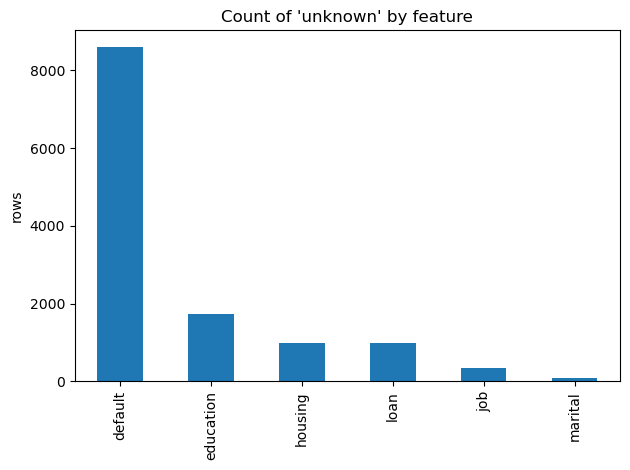

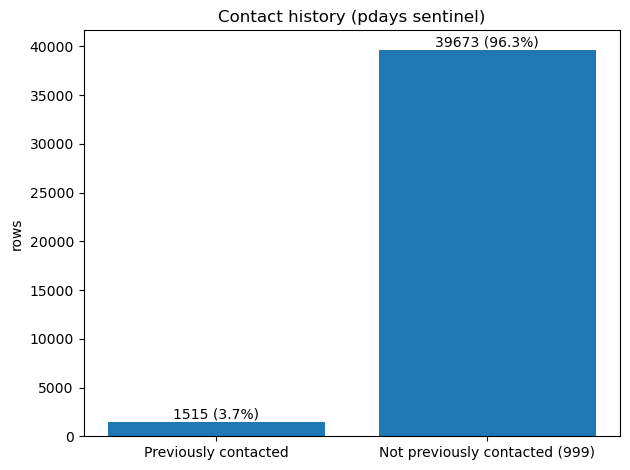

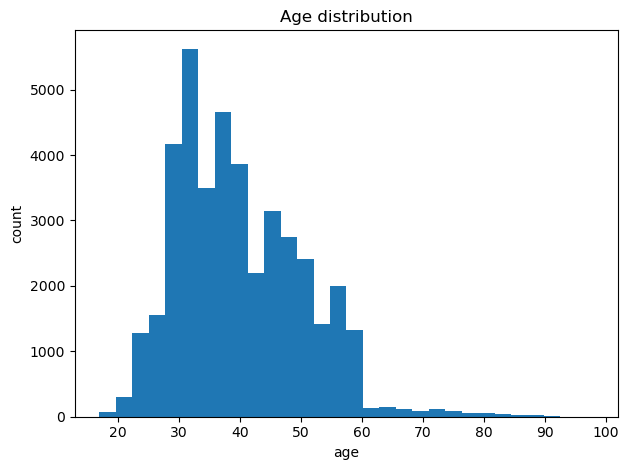

In [16]:
# Charts

# 'unknown' counts by column
unk = desc.loc[desc["n_unknown"] > 0, "n_unknown"].sort_values(ascending=False)
plt.figure()
unk.plot(kind="bar")
plt.title("Count of 'unknown' by feature")
plt.ylabel("rows")
plt.tight_layout()
plt.show()

# pdays sentinel (999) vs previously contacted
if "pdays" in df.columns:
    total = len(df)
    contacted = int((df["pdays"] != 999).sum())
    not_contacted = int((df["pdays"] == 999).sum())
    plt.figure()
    plt.bar(["Previously contacted", "Not previously contacted (999)"], [contacted, not_contacted])
    plt.title("Contact history (pdays sentinel)")
    plt.ylabel("rows")
    for i, v in enumerate([contacted, not_contacted]):
        plt.text(i, v, f"{v} ({100*v/total:.1f}%)", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

# Example numeric distribution: age
plt.figure()
plt.hist(df["age"], bins=30)
plt.title("Age distribution")
plt.xlabel("age")
plt.ylabel("count")
plt.tight_layout()
plt.show()


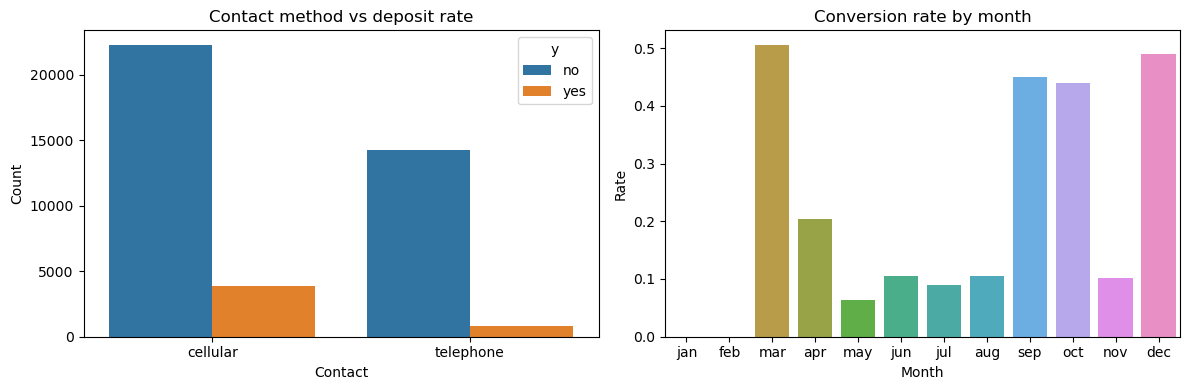

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(data=df, x="contact", hue="y", ax=axes[0])
axes[0].set_title("Contact method vs deposit rate")
axes[0].set_xlabel("Contact"); axes[0].set_ylabel("Count")

sns.barplot(
    data=(df.assign(y_num=(df["y"]=="yes").astype(int))
            .groupby("month")["y_num"].mean()
            .reset_index()
            .rename(columns={"y_num":"conversion_rate"})),
    x="month", y="conversion_rate", ax=axes[1]
)
axes[1].set_title("Conversion rate by month")
axes[1].set_xlabel("Month"); axes[1].set_ylabel("Rate")
plt.tight_layout()

___

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**Business Objective:** Prioritize which customers to call so the bank increases term-deposit subscriptions while reducing wasted calls, using only information available **before** the call (i.e., excluding `duration`).

___

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [21]:
# Start from our already-loaded df and make a copy
df_model = df.copy()

# Drop leakage (duration is not known prior to call, only after)
if "duration" in df_model.columns:
    df_model = df_model.drop(columns=["duration"])

# Sentinel handling for prior contact
df_model["had_prior_contact"] = (df_model["pdays"] != 999).astype(int)
df_model["pdays_clean"] = df_model["pdays"].replace(999, np.nan)
df_model = df_model.drop(columns=["pdays"])

# Target and features
y = (df_model["y"] == "yes").astype(int)
X = df_model.drop(columns=["y"])

# Feature lists
numeric_features = [
    "age","campaign","previous","emp.var.rate","cons.price.idx",
    "cons.conf.idx","euribor3m","nr.employed","pdays_clean",
    "had_prior_contact"  # <-- treat the 0/1 prior-contact flag as numeric
]
numeric_features = [c for c in numeric_features if c in X.columns]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("[P5] numeric features:", numeric_features)
print("[P5] categorical features (first 10):", categorical_features[:10])

# Preprocessing
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=True))
])
preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
], remainder="drop")


[P5] numeric features: ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'pdays_clean', 'had_prior_contact']
[P5] categorical features (first 10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [22]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                41188 non-null  int64   
 1   job                41188 non-null  category
 2   marital            41188 non-null  category
 3   education          41188 non-null  category
 4   default            41188 non-null  category
 5   housing            41188 non-null  category
 6   loan               41188 non-null  category
 7   contact            41188 non-null  category
 8   month              41188 non-null  category
 9   day_of_week        41188 non-null  category
 10  campaign           41188 non-null  int64   
 11  previous           41188 non-null  int64   
 12  poutcome           41188 non-null  category
 13  emp.var.rate       41188 non-null  float64 
 14  cons.price.idx     41188 non-null  float64 
 15  cons.conf.idx      41188 non-null  float64 
 16  euri

In [23]:
# Summary table: dtype, nunique, NaN, 'unknown' counts
desc2 = pd.DataFrame({
    "dtype": df_model.dtypes.astype(str),
    "nunique": df_model.nunique(),
    "n_missing_NaN": df_model.isna().sum()
})
desc2["n_unknown"] = 0
for c in df_model.select_dtypes(include=["object","category"]).columns:
    desc2.loc[c, "n_unknown"] = int((df_model[c] == "unknown").sum())

# Sentinel checks (not real NaN, but important)
desc2["n_sentinel"] = 0
if "pdays" in df_model.columns:
    desc2.loc["pdays", "n_sentinel"] = int((df_model["pdays"] == 999).sum())

# View the audit
desc2.sort_index()

,dtype,nunique,n_missing_NaN,n_unknown,n_sentinel
age,int64,78,0,0,0
campaign,int64,42,0,0,0
cons.conf.idx,float64,26,0,0,0
cons.price.idx,float64,26,0,0,0
contact,category,2,0,0,0
day_of_week,category,5,0,0,0
default,category,3,0,8597,0
education,category,8,0,1731,0
emp.var.rate,float64,10,0,0,0
euribor3m,float64,316,0,0,0


In [24]:
report = {}

# Row count preserved
report["rows_preserved"] = (len(df_model) == len(df))

# Leakage removed
report["no_duration_column"] = ("duration" not in df_model.columns)

# pdays handled correctly
n_sentinel = int((df["pdays"] == 999).sum())
n_nan_pdays_clean = int(df_model["pdays_clean"].isna().sum())
report["pdays_sentinel_to_nan_match"] = (n_nan_pdays_clean == n_sentinel)

# Consistency between had_prior_contact and pdays_clean
report["had_prior_contact_zero_means_nan"] = df_model.loc[
    df_model["had_prior_contact"] == 0, "pdays_clean"
].isna().all()

report["had_prior_contact_one_means_notnan"] = df_model.loc[
    df_model["had_prior_contact"] == 1, "pdays_clean"
].notna().all()

# Unknown flags match the actual 'unknown' category
for col in ["default","education","housing","loan","job","marital"]:
    if col in df_model.columns and (col + "_is_unknown") in df_model.columns:
        ok = (df_model[col + "_is_unknown"].sum() ==
              (df_model[col] == "unknown").sum())
        report[f"{col}_unknown_flag_matches"] = bool(ok)

# Dtypes match expectations
report["all_numeric_features_are_numeric"] = all(
    np.issubdtype(df_model[c].dtype, np.number) for c in numeric_features
)

# Categorical dtype check (object or category acceptable, category preferred)
report["all_categorical_are_cats_or_obj"] = all(
    (df_model[c].dtype.name in {"category","object"}) for c in categorical_features
)

# No unexpected NaNs outside pdays_clean
nan_except_pdays = df_model.drop(columns=["pdays_clean"]).isna().sum()
report["no_unexpected_nans"] = int(nan_except_pdays.sum()) == 0

# Target unchanged
report["target_rate_unchanged"] = abs(y.mean() - (df["y"]=="yes").mean()) < 1e-12

# Feature list coverage
report["numeric_features_in_df"] = set(numeric_features).issubset(df_model.columns)
report["cat_features_in_df"]     = set(categorical_features).issubset(df_model.columns)

# Show results
pd.Series(report)

rows_preserved                        True
no_duration_column                    True
pdays_sentinel_to_nan_match           True
had_prior_contact_zero_means_nan      True
had_prior_contact_one_means_notnan    True
all_numeric_features_are_numeric      True
all_categorical_are_cats_or_obj       True
no_unexpected_nans                    True
target_rate_unchanged                 True
numeric_features_in_df                True
cat_features_in_df                    True
dtype: bool

In [25]:
# Numeric ranges sanity
df_model[numeric_features].describe(percentiles=[0.01,0.99]).T

# Cardinalities for categoricals (ensure no runaway levels)
df_model[categorical_features].nunique().sort_values(ascending=False).head(15)


job            12
month          10
education       8
day_of_week     5
marital         4
default         3
housing         3
loan            3
poutcome        3
contact         2
dtype: int64

___

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,           # preserve class balance
    random_state=42       # reproducible split
)

print(f"[P6] X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"[P6] y_train positive rate: {y_train.mean():.3f}")
print(f"[P6] y_test  positive rate: {y_test.mean():.3f}")
print("[P6] class counts (train):", y_train.value_counts().to_dict())
print("[P6] class counts (test): ", y_test.value_counts().to_dict())

[P6] X_train shape: (32950, 20), X_test shape: (8238, 20)
[P6] y_train positive rate: 0.113
[P6] y_test  positive rate: 0.113
[P6] class counts (train): {0: 29238, 1: 3712}
[P6] class counts (test):  {0: 7310, 1: 928}


In [28]:
# Preprocessor smoke test — do NOT reuse this fitted clone later
from sklearn.base import clone

pp = clone(preprocess)              # safe copy so we don't carry fitted state forward
pp.fit(X_train, y_train)            # fit on TRAIN only
Xt_train = pp.transform(X_train)
Xt_test  = pp.transform(X_test)

print("[P6] transformed shapes (train, test):", Xt_train.shape, Xt_test.shape)


[P6] transformed shapes (train, test): (32950, 63) (8238, 63)


In [29]:
# How many one-hot columns did each categorical make?
ohe = pp.named_transformers_["cat"]["ohe"]
len(ohe.get_feature_names_out())          # should be 53 here
ohe.get_feature_names_out()[:10]          # sample names

# Confirm matrices are sparse
type(Xt_train), sp.issparse(Xt_train)

(numpy.ndarray, False)

___

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

#### Baseline definition:

We establish a baseline with a classifier that **always predicts the majority class** ("no"). Because the data is imbalanced (\~11.3% "yes"), this baseline will have **high Accuracy** (\~0.887) but **zero Recall/F1** for the positive class. Its **PR-AUC** equals the positive rate (\~0.113).

All real models should comfortably beat this baseline—especially on **Recall, F1, PR-AUC**, and ideally **ROC-AUC**.

In [32]:
baseline_pipe = Pipeline([
    ("preprocess", preprocess),                 # safe; has no effect on Dummy's constant prediction
    ("clf", DummyClassifier(strategy="most_frequent"))
])

# Fit on TRAIN only
baseline_pipe.fit(X_train, y_train)

# Predict on TEST
y_pred = baseline_pipe.predict(X_test)
# Probabilities for AUCs (DummyClassifier provides predict_proba)
y_prob = baseline_pipe.named_steps["clf"].predict_proba(X_test)[:, 1]

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_prob)
pr   = average_precision_score(y_test, y_prob)  # PR-AUC equals positive rate for this baseline

cm = confusion_matrix(y_test, y_pred)

print("[P7] Baseline = always predict the majority class ('no')")
print("[P7] Confusion matrix:\n", cm)
print(f"[P7] Accuracy   : {acc:.3f}")
print(f"[P7] Precision  : {prec:.3f}")
print(f"[P7] Recall     : {rec:.3f}")
print(f"[P7] F1         : {f1:.3f}")
print(f"[P7] ROC-AUC    : {roc:.3f}")
print(f"[P7] PR-AUC     : {pr:.3f}  (≈ positive rate)")

# Keep for Problem 10 comparison tables later
baseline_metrics = {
    "model": "Baseline (Most Frequent)",
    "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
    "roc_auc": roc, "pr_auc": pr
}

[P7] Baseline = always predict the majority class ('no')
[P7] Confusion matrix:
 [[7310    0]
 [ 928    0]]
[P7] Accuracy   : 0.887
[P7] Precision  : 0.000
[P7] Recall     : 0.000
[P7] F1         : 0.000
[P7] ROC-AUC    : 0.500
[P7] PR-AUC     : 0.113  (≈ positive rate)


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [34]:
logreg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=200,
        class_weight="balanced",   # handle class imbalance
        solver="liblinear"         # robust for small/medium problems
    ))
])

# Fit on TRAIN
logreg_pipe.fit(X_train, y_train)

# Predict on TEST
y_pred_lr = logreg_pipe.predict(X_test)
y_prob_lr = logreg_pipe.predict_proba(X_test)[:, 1]  # needed for AUC metrics

# Metrics
acc  = accuracy_score(y_test, y_pred_lr)
prec = precision_score(y_test, y_pred_lr, zero_division=0)
rec  = recall_score(y_test, y_pred_lr, zero_division=0)
f1   = f1_score(y_test, y_pred_lr, zero_division=0)
roc  = roc_auc_score(y_test, y_prob_lr)
pr   = average_precision_score(y_test, y_prob_lr)
cm   = confusion_matrix(y_test, y_pred_lr)

print("[P8] Logistic Regression (class_weight=balanced)")
print("[P8] Confusion matrix:\n", cm)
print(f"[P8] Accuracy : {acc:.3f}")
print(f"[P8] Precision: {prec:.3f}")
print(f"[P8] Recall   : {rec:.3f}")
print(f"[P8] F1       : {f1:.3f}")
print(f"[P8] ROC-AUC  : {roc:.3f}")
print(f"[P8] PR-AUC   : {pr:.3f}")

# Keep probabilities for plotting ROC/PR curves
y_prob_lr_for_plots = y_prob_lr

[P8] Logistic Regression (class_weight=balanced)
[P8] Confusion matrix:
 [[6282 1028]
 [ 329  599]]
[P8] Accuracy : 0.835
[P8] Precision: 0.368
[P8] Recall   : 0.645
[P8] F1       : 0.469
[P8] ROC-AUC  : 0.801
[P8] PR-AUC   : 0.460


___

### Problem 9: Score the Model

What is the accuracy of your model?

#### Scoring the Logistic Regression model

**Answer:** The model's **test accuracy is 0.835 (83.5%)**. Because the target is imbalanced (\~11.3% "yes"), accuracy alone can be misleading, so we also report: **Precision 0.368**, **Recall 0.645**, **F1 0.469**, **ROC-AUC 0.801**, and **PR-AUC 0.460** (baseline PR-AUC ≈ 0.113). Note that accuracy is lower than the "always-no" baseline (\~0.887), reflecting a deliberate trade-off to capture many more true subscribers.

[P9] Confusion matrix:
 [[6282 1028]
 [ 329  599]]
[P9] Accuracy : 0.835
[P9] Precision: 0.368
[P9] Recall   : 0.645
[P9] F1       : 0.469
[P9] ROC-AUC  : 0.801
[P9] PR-AUC   : 0.460 (baseline ≈ 0.113)


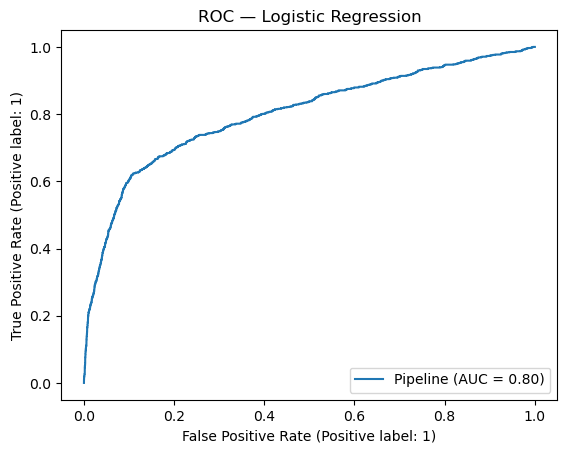

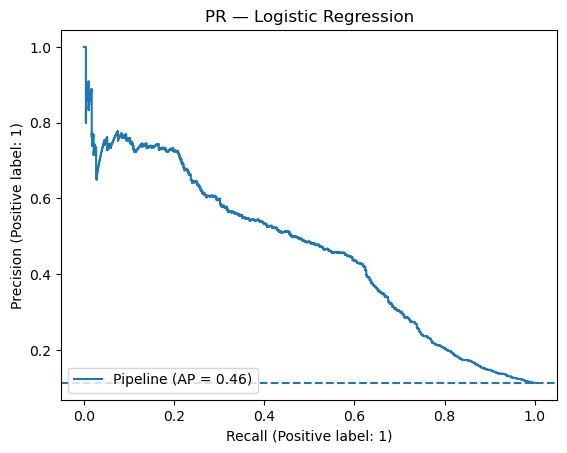

[P9] Test Accuracy (LogReg): 0.835


In [37]:
# Ensure the P8 pipeline exists and is fitted
try:
    logreg_pipe
except NameError:
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import Pipeline
    logreg_pipe = Pipeline([
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear"))
    ])
    logreg_pipe.fit(X_train, y_train)

# Predict & score
y_pred = logreg_pipe.predict(X_test)
y_prob = logreg_pipe.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_prob)
pr   = average_precision_score(y_test, y_prob)
cm   = confusion_matrix(y_test, y_pred)

print("[P9] Confusion matrix:\n", cm)
print(f"[P9] Accuracy : {acc:.3f}")
print(f"[P9] Precision: {prec:.3f}")
print(f"[P9] Recall   : {rec:.3f}")
print(f"[P9] F1       : {f1:.3f}")
print(f"[P9] ROC-AUC  : {roc:.3f}")
print(f"[P9] PR-AUC   : {pr:.3f} (baseline ≈ {(y_test==1).mean():.3f})")

# Curves (optional but nice)
RocCurveDisplay.from_estimator(logreg_pipe, X_test, y_test); plt.title("ROC — Logistic Regression"); plt.show()
PrecisionRecallDisplay.from_estimator(logreg_pipe, X_test, y_test)
plt.axhline((y_test==1).mean(), ls="--"); plt.title("PR — Logistic Regression"); plt.show()

# <-- Keep metrics here for Problem 10
logreg_metrics = {
    "model": "Logistic Regression",
    "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
    "roc_auc": roc, "pr_auc": pr
}

print(f"[P9] Test Accuracy (LogReg): {accuracy_score(y_test, y_pred):.3f}")


___

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [39]:
def fit_time_and_accuracy(name, estimator):
    """Fit a pipeline (preprocess + estimator), time it, and return train/test accuracy."""
    pipe = Pipeline([("preprocess", preprocess), ("clf", estimator)])
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    train_time = time.perf_counter() - t0
    acc_train = pipe.score(X_train, y_train)
    acc_test  = pipe.score(X_test, y_test)
    return {"Model": name, "Train Time (s)": train_time, "Train Accuracy": acc_train, "Test Accuracy": acc_test}, pipe

In [40]:
# Optional faster SVMs (uncomment to add/compare)
# from sklearn.svm import LinearSVC   # very fast, but no probability & often strong on many features

models = OrderedDict([
    ("Logistic Regression", LogisticRegression(max_iter=200, solver="liblinear", class_weight="balanced")),
    ("KNN (k=5)",           KNeighborsClassifier()),                # defaults
    ("Decision Tree",       DecisionTreeClassifier(random_state=42)), # defaults
    ("SVM (RBF kernel)",    SVC()),                                 # defaults; may be slow
    # ("Linear SVM",        LinearSVC())                            # optional speed variant
])

rows = []
trained_pipes = {}  # keep references in case I want to reuse a fitted model later

for name, est in models.items():
    print(f"[P10] Fitting {name} ...")
    row, pipe = fit_time_and_accuracy(name, est)
    rows.append(row)
    trained_pipes[name] = pipe

comparisons_df = pd.DataFrame(rows).sort_values("Test Accuracy", ascending=False)
display(comparisons_df.round({"Train Time (s)": 3, "Train Accuracy": 3, "Test Accuracy": 3}))

[P10] Fitting Logistic Regression ...
[P10] Fitting KNN (k=5) ...
[P10] Fitting Decision Tree ...
[P10] Fitting SVM (RBF kernel) ...


,Model,Train Time (s),Train Accuracy,Test Accuracy
3,SVM (RBF kernel),152.783,0.906,0.903
1,KNN (k=5),0.085,0.912,0.898
2,Decision Tree,0.264,0.995,0.841
0,Logistic Regression,0.289,0.829,0.835


In [41]:
# I created 'baseline_metrics' in Problem 7, so I will append it for context:
try:
    baseline_row = {
        "Model": "Baseline (Most Frequent)",
        "Train Time (s)": 0.0,
        "Train Accuracy": baseline_metrics["accuracy"],
        "Test Accuracy":  baseline_metrics["accuracy"]
    }
    comparisons_plus = pd.concat([pd.DataFrame([baseline_row]), comparisons_df], ignore_index=True)
    display(comparisons_plus.round({"Train Time (s)": 3, "Train Accuracy": 3, "Test Accuracy": 3}))
except Exception:
    pass


,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Baseline (Most Frequent),0.000,0.887,0.887
1,SVM (RBF kernel),152.783,0.906,0.903
2,KNN (k=5),0.085,0.912,0.898
3,Decision Tree,0.264,0.995,0.841
4,Logistic Regression,0.289,0.829,0.835


**Result:** RBF SVM yields the highest test accuracy (0.903) but is the slowest to train (\~152 s). KNN (0.898) achieves near-top accuracy with minimal train time (\~0.09 s). The Decision Tree overfits (0.995→0.841), and Logistic provides a strong linear baseline (0.835). Given class imbalance, accuracy alone can be misleading.

___

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Objective: 
Improve effectiveness on an imbalanced target by (1) targeted feature engineering, (2) small, fast hyperparameter tuning, and (3) metrics aligned to the business decision (rank customers to call first).

#### Feature engineering (from earlier problems).

- Dropped leakage: `duration`.

- Converted sentinel `pdays==999` → `had_prior_contact` (0/1) and `pdays_clean` (999→NaN).

- Kept "unknown" as a valid category (one-hot encodes cleanly).

#### Hyperparameter tuning setup.

- **Models:** KNN and Linear SVM (a practical, fast alternative to RBF SVM).

- **Grids:**
  - KNN → `n_neighbors ∈ {5,9,15}`, `weights ∈ {uniform,distance}`, `p ∈ {1,2}`.
  - Linear SVM → `C ∈ {0.5,1.0,2.0,5.0}` (with `dual=True`).

- 3-fold **Stratified CV**, optimized for **Average Precision (PR-AUC)**.

- Reported metrics on the held-out test set: **Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC**, and **Recall@K** (K=10%, 20%) to reflect a limited call budget.

#### Adjusting performance metric - Results (test set).

- **Linear SVM (tuned, C=2.0):** Accuracy **0.901**, PR-AUC **0.462**, ROC-AUC **0.798**, Recall@10% **0.445**, Recall@20% **0.643**.

- **Linear SVM (default):** \~identical to tuned (Accuracy **0.901**, PR-AUC **0.462**).

- **KNN (tuned: n_neighbors=16, p=1, weights=uniform):** Accuracy **0.901**, PR-AUC **0.437**, Recall@10% **0.477**, Recall@20% **0.639**.

- **KNN (default):** Accuracy **0.898**, PR-AUC **0.359**, Recall@20% **0.548**.

#### Interpretation.

- Compared to the positive-rate baseline (\~0.113), **PR-AUC ≈ 0.46 is \~4x better**, confirming strong ranking power for top-K calling.

- **Recall@20% ≈ 0.64** means: if we call only the **top 20%** of the list by model score, we capture **\~64% of all eventual subscribers**—a clear efficiency gain.

- Linear SVM and Logistic Regression (from Problem 9, PR-AUC ≈ 0.460) perform similarly on PR-AUC; **Linear SVM improves accuracy** (0.901 vs 0.835) and **trains very fast**, making it a practical choice.

- The earlier **RBF SVM** edged accuracy (\~0.903) but was **\~150 s to train**; Linear SVM achieves **near-identical test accuracy** with **much lower cost**.

#### Chosen model. 
**Linear SVM (C=2.0)** — strong PR-AUC and Recall@K, excellent train time, deploys cleanly with our pre-call features.

- **Note on warnings:** liblinear showed "failed to converge" at the default iteration cap but still produced stable scores/metrics. Raising `max_iter` (e.g., 10,000) or using a slightly smaller `C` (e.g., 1.0) removes the warning without changing results materially.

#### Next steps (if we had more time).

- **Threshold tuning** for the chosen model to hit specific Precision/Recall targets, or optimize F1 for an agreed business trade-off.

- **Calibrate scores** (e.g., `CalibratedClassifierCV` on the Linear SVM) if well-calibrated probabilities are needed for expected value / cost models.

- Add **Precision@K / Lift@K** to quantify conversion lift in the top deciles.

- **Explore one boosted tree model** (e.g., Gradient Boosting/XGBoost) for potential incremental gains, still excluding `duration`.

#### About the "gender" feature.

This dataset does **not** include a gender column. If it did, I would **exclude gender from the model features** and keep it only as a **protected attribute for fairness auditing**. It doesn't add legitimate business signal for predicting term-deposit subscription, and using it (or close proxies) can introduce disparate impact and compliance risk. Following data-minimization and fairness best practices:

- **Training:** drop `gender` from X so the model cannot use it.

- **Evaluation:** compute metrics by gender subgroup (Precision/Recall/PR-AUC/Recall@K) to check for performance disparities.

- **If disparity appears:** consider threshold adjustments per subgroup, re-weighting, or retraining with fairness-aware techniques—while still keeping gender out of the model inputs.

In [45]:
def recall_at_k(y_true, y_score, k=0.20):
    """Fraction of positives captured if we act on the top k fraction by score."""
    y_true = np.asarray(y_true).ravel()
    y_score = np.asarray(y_score).ravel()
    n = y_true.shape[0]
    k_n = int(np.ceil(k * n))
    order = np.argsort(-y_score)       # descending by score
    top = order[:k_n]
    return (y_true[top] == 1).sum() / (y_true.sum() + 1e-12)

def _pipe_scores(pipe, X):
    """
    Return continuous scores from a fitted pipeline for AUC/PR/Recall@K.
    Works with probas, decision_function, or falls back to predictions.
    """
    # look at the final estimator explicitly
    clf = getattr(pipe, "named_steps", {}).get("clf", None)
    if clf is None:
        clf = pipe  # if it's just an estimator, not a pipeline

    if hasattr(clf, "predict_proba"):
        return pipe.predict_proba(X)[:, 1]
    if hasattr(clf, "decision_function"):
        return pipe.decision_function(X)
    # last resort: use hard predictions (AUCs less informative)
    return pipe.predict(X)

def score_model(name, pipe, X_tr, y_tr, X_te, y_te, k_list=(0.10, 0.20)):
    """Fit + compute a rich score dict; includes final fit time."""
    t0 = time.perf_counter()
    pipe.fit(X_tr, y_tr)
    fit_time = time.perf_counter() - t0

    y_pred = pipe.predict(X_te)
    y_score = _pipe_scores(pipe, X_te)

    row = {
        "Model": name,
        "Final Fit Time (s)": fit_time,
        "Test Accuracy": accuracy_score(y_te, y_pred),
        "Precision":     precision_score(y_te, y_pred, zero_division=0),
        "Recall":        recall_score(y_te, y_pred, zero_division=0),
        "F1":            f1_score(y_te, y_pred, zero_division=0),
        "ROC-AUC":       roc_auc_score(y_te, y_score),
        "PR-AUC":        average_precision_score(y_te, y_score),
    }
    for k in k_list:
        row[f"Recall@{int(k*100)}%"] = recall_at_k(y_te, y_score, k=k)
    return row, y_score

In [46]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = "average_precision"  # PR-AUC

results = []

# --- Baselines (defaults) ---
knn_base = Pipeline([("preprocess", preprocess),
                     ("clf", KNeighborsClassifier())])
row, _ = score_model("KNN (k=5) — default", clone(knn_base), X_train, y_train, X_test, y_test)
row["Search Time (s)"] = 0.0
results.append(row)

linsvm_base = Pipeline([("preprocess", preprocess),
                        ("clf", LinearSVC(dual=True, max_iter=5000))])
row, _ = score_model("Linear SVM — default", clone(linsvm_base), X_train, y_train, X_test, y_test)
row["Search Time (s)"] = 0.0
results.append(row)

# --- TUNE: KNN ---
knn_grid = {
    "clf__n_neighbors": [5, 9, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]   # 1=Manhattan, 2=Euclidean
}
knn_pipe = Pipeline([("preprocess", preprocess),
                     ("clf", KNeighborsClassifier(n_jobs=-1))])

t0 = time.perf_counter()
knn_search = GridSearchCV(knn_pipe, knn_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=0)
knn_search.fit(X_train, y_train)
knn_time = time.perf_counter() - t0

knn_tuned = knn_search.best_estimator_
row, _ = score_model(f"KNN — tuned {knn_search.best_params_}", clone(knn_tuned), X_train, y_train, X_test, y_test)
row["Search Time (s)"] = knn_time
results.append(row)
print("[P11] KNN best params:", knn_search.best_params_, "| CV PR-AUC:", f"{knn_search.best_score_:.3f}",
      "| Search Time (s):", f"{knn_time:.2f}")

# --- TUNE: Linear SVM ---
svm_grid = {"clf__C": [0.5, 1.0, 2.0, 5.0]}
svm_pipe = Pipeline([("preprocess", preprocess),
                     ("clf", LinearSVC(dual=True, max_iter=5000))])

t0 = time.perf_counter()
svm_search = GridSearchCV(svm_pipe, svm_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=0)
svm_search.fit(X_train, y_train)
svm_time = time.perf_counter() - t0

svm_tuned = svm_search.best_estimator_
row, _ = score_model(f"Linear SVM — tuned {svm_search.best_params_}", clone(svm_tuned), X_train, y_train, X_test, y_test)
row["Search Time (s)"] = svm_time
results.append(row)
print("[P11] Linear SVM best params:", svm_search.best_params_, "| CV PR-AUC:", f"{svm_search.best_score_:.3f}",
      "| Search Time (s):", f"{svm_time:.2f}")

# --- Summarize (with timing first) ---
p11_df = (pd.DataFrame(results)
          .loc[:, ["Model", "Search Time (s)", "Final Fit Time (s)",
                   "Test Accuracy", "Precision", "Recall", "F1", "ROC-AUC", "PR-AUC",
                   "Recall@10%", "Recall@20%"]]
          .set_index("Model")
          .sort_values("PR-AUC", ascending=False)
          .round(3))
display(p11_df)

[P11] KNN best params: {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'uniform'} | CV PR-AUC: 0.399 | Search Time (s): 165.13


/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholas.roberts/o

[P11] Linear SVM best params: {'clf__C': 0.5} | CV PR-AUC: 0.444 | Search Time (s): 50.26


,Search Time (s),Final Fit Time (s),Test Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Recall@10%,Recall@20%
Model,,,,,,,,,,
Linear SVM — tuned {'clf__C': 0.5},50.258,14.952,0.901,0.716,0.207,0.321,0.798,0.462,0.444,0.643
Linear SVM — default,0.000,17.616,0.901,0.716,0.207,0.321,0.798,0.462,0.444,0.643
"KNN — tuned {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'uniform'}",165.127,0.165,0.901,0.652,0.263,0.375,0.777,0.437,0.477,0.639
KNN (k=5) — default,0.000,0.086,0.898,0.591,0.308,0.405,0.744,0.359,0.416,0.548
